In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import seaborn as sns

sys.path.append(r"D:\github\ripple_heterogeneity\python")
import functions, loading

sys.path.append(r"D:\github\neurocode\reactivation\assemblies")
import assembly
import assembly_reactivation
import assembly_individual_epochs

import nelpy as nel

import os

import pickle
import glob

from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import random
from tqdm import tqdm


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

functions.set_plotting_defaults()

## Make pre/task/post assembly activation strength for novel sessions

In [ ]:
# save_path_assembly = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly"
# sessions = glob.glob(save_path_assembly + os.sep + "*.pkl")
# sessions = [string for string in sessions if "GrosmarkAD" in string]

# basepath = []
# for session in sessions:
#     with open(session, "rb") as f:
#         results = pickle.load(f)
#     basepath.append(results["basepath"])

# temp_df = pd.DataFrame()
# temp_df["basepath"] = basepath

# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_activation"

# assembly_activation.assembly_run_activation(
#     temp_df, save_path, save_path_assembly, parallel=False
# )


In [9]:
basepath = r"Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"

results = assembly_reactivation.get_pre_post_assembly_strengths(basepath)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:392: UserWarning: Data is _not_ sorted! Data will be sorted automatically.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:392: UserWarning: Data is _not_ sorted! Data will be sorted automatically.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smal

In [10]:
import add_new_deep_sup

UID = []
deepSuperficial = []
weights = []
membership = []
df = pd.DataFrame()
assembly_n = []
assembly_ = []
basepath_ = []
assembly_path = []

# detect significant assemblies and assembly members
(
    patterns,
    is_member_keep,
    keep_assembly,
    is_member,
) = functions.find_sig_assemblies(results["react"].patterns)

# get deep/superficial classification
cell_metrics = add_new_deep_sup.add_new_deep_sup_class(results["react"].cell_metrics)

# iterate through assemblies
for i_assemblies, pattern in enumerate(results["react"].patterns):

    UID.append(cell_metrics["UID"])
    deepSuperficial.append(cell_metrics["deepSuperficial"])
    weights.append(pattern)
    membership.append(is_member[i_assemblies])
    assembly_.append([assembly_n] * len(pattern))
    assembly_n.append(np.tile(i_assemblies,len(pattern)))
    basepath_.append([basepath] * len(pattern))

df["UID"] = np.hstack(UID)
df["basepath"] = np.hstack(basepath_)
df["deepSuperficial"] = np.hstack(deepSuperficial)
df["weights"] = np.hstack(weights)
df["membership"] = np.hstack(membership)
df["assembly_n"] = np.hstack(assembly_n)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


## get deep/sup class of assemblies

In [94]:
for n_as in df.assembly_n.unique():
    current_df = df[df.assembly_n == n_as]
    mem_idx = current_df.membership == True
    sup_idx = current_df.deepSuperficial == "Superficial"
    deep_idx = current_df.deepSuperficial == "Deep"

    if ((deep_idx & mem_idx).sum() > 0) & ((sup_idx & mem_idx).sum() > 0):
        layer_id = 'mixed'
    elif ((deep_idx & mem_idx).sum() > 1) & ((sup_idx & mem_idx).sum() == 0):
        layer_id = 'deep'
    elif ((deep_idx & mem_idx).sum() == 0) & ((sup_idx & mem_idx).sum() > 0):
        layer_id = 'sup'
    else:
        layer_id = 'unknown'
    df.loc[df.assembly_n == n_as, "layer_id"] = layer_id

sup_idx = df.assembly_n[df.layer_id == "sup"].unique()
deep_idx = df.assembly_n[df.layer_id == "deep"].unique()


## compile peak reactivation strength per ripple

For pre and post for deep and superficial only assemblies

In [42]:
import copy
import warnings
warnings.filterwarnings("ignore")

react_df = pd.DataFrame()

temp_df = pd.DataFrame()
assembly_act_pre = copy.deepcopy(results["assembly_act_pre"])
assembly_act_pre.data = assembly_act_pre.data[deep_idx, :]
assembly_id, strengths = assembly_reactivation.get_peak_activity(
    assembly_act_pre, results["react"].ripples[results["react"].epochs[0]]
)
temp_df["strength"] = np.hstack(strengths)
temp_df["deepSuperficial"] = "deep"
temp_df["epoch"] = "pre"
react_df = pd.concat([react_df, temp_df], ignore_index=True)

temp_df = pd.DataFrame()
assembly_act_post = copy.deepcopy(results["assembly_act_post"])
assembly_act_post.data = assembly_act_post.data[deep_idx, :]
assembly_id, strengths = assembly_reactivation.get_peak_activity(
    assembly_act_post, results["react"].ripples[results["react"].epochs[2]]
)
temp_df["strength"] = np.hstack(strengths)
temp_df["deepSuperficial"] = "deep"
temp_df["epoch"] = "post"
react_df = pd.concat([react_df, temp_df], ignore_index=True)

temp_df = pd.DataFrame()
assembly_act_pre = copy.deepcopy(results["assembly_act_pre"])
assembly_act_pre.data = assembly_act_pre.data[sup_idx, :]
assembly_id, strengths = assembly_reactivation.get_peak_activity(
    assembly_act_pre, results["react"].ripples[results["react"].epochs[0]]
)
temp_df["strength"] = np.hstack(strengths)
temp_df["deepSuperficial"] = "sup"
temp_df["epoch"] = "pre"
react_df = pd.concat([react_df, temp_df], ignore_index=True)

temp_df = pd.DataFrame()
assembly_act_post = copy.deepcopy(results["assembly_act_post"])
assembly_act_post.data = assembly_act_post.data[sup_idx, :]
assembly_id, strengths = assembly_reactivation.get_peak_activity(
    assembly_act_post, results["react"].ripples[results["react"].epochs[2]]
)
temp_df["strength"] = np.hstack(strengths)
temp_df["deepSuperficial"] = "sup"
temp_df["epoch"] = "post"
react_df = pd.concat([react_df, temp_df], ignore_index=True)

react_df['layer_epoch'] = react_df.deepSuperficial + '_' + react_df.epoch

react_df

,strength,deepSuperficial,epoch
0,0.392722,deep,pre
1,2.546966,deep,pre
2,0.625300,deep,pre
3,0.924817,deep,pre
4,1.023154,deep,pre
...,...,...,...
32143,0.389175,sup,post
32144,1.949405,sup,post
32145,2.532269,sup,post
32146,0.823681,sup,post


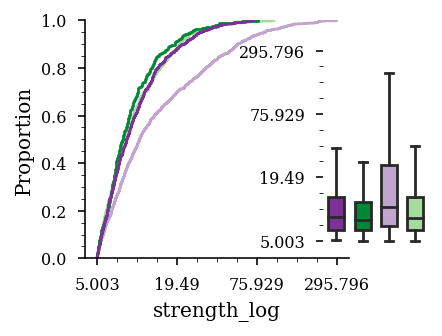

In [92]:
import custom_plots

# group_colors = {"deep": "#7b3294", "sup": "#008837"}

group_colors = {
    "deep_pre": "#7b3294",
    "sup_pre": "#008837",
    "deep_post": "#c2a5cf",
    "sup_post": "#a6dba0",
}

sns.set_palette(sns.color_palette(group_colors.values()))

fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)),
    edgecolor=None,
)
react_df["strength_log"] = np.log10(react_df["strength"])
box_ax = custom_plots.plot_ecdf_box(
    data=react_df[react_df.strength >= 5],
    x="strength_log",
    hue="layer_epoch",
    hue_order=group_colors.keys(),
    x_offset=0.7,
    showfliers=False,
    height_ratio=1.2,
    ax=ax,
    fig=fig,
)
# ax.set_xscale('log')
# box_ax.set_yscale('log')
# box_ax.legend()
custom_plots.restore_natural_scale(
    ax,
    react_df[react_df.strength >= 5].strength_log.min(),
    react_df[react_df.strength >= 5].strength_log.max(),
    n_steps=4,
    x_axis=True,
    y_axis=False,
)
custom_plots.restore_natural_scale(
    box_ax,
    react_df[react_df.strength >= 5].strength_log.min(),
    react_df[react_df.strength >= 5].strength_log.max(),
    n_steps=4,
    x_axis=False,
    y_axis=True,
)

In [14]:
react_df_sup = pd.DataFrame()
react_df_sup["strength"] = np.hstack(
    [
        np.hstack(results["assembly_act_pre"].data[sup_idx, :]),
        np.hstack(results["assembly_act_post"].data[sup_idx, :]),
    ]
)
react_df_sup["epoch"] = np.hstack(
    [
        ['pre']*len(np.hstack(results["assembly_act_pre"].data[sup_idx, :])),
        ['post']*len(np.hstack(results["assembly_act_post"].data[sup_idx, :])),
    ]
)
react_df_sup['deepSuperficial'] = 'sup'

react_df_deep = pd.DataFrame()
react_df_deep["strength"] = np.hstack(
    [
        np.hstack(results["assembly_act_pre"].data[deep_idx, :]),
        np.hstack(results["assembly_act_post"].data[deep_idx, :]),
    ]
)
react_df_deep["epoch"] = np.hstack(
    [
        ['pre']*len(np.hstack(results["assembly_act_pre"].data[deep_idx, :])),
        ['post']*len(np.hstack(results["assembly_act_post"].data[deep_idx, :])),
    ]
)
react_df_deep['deepSuperficial'] = 'deep'

react_df = pd.DataFrame()
react_df = pd.concat([react_df_sup, react_df_deep],ignore_index=True)
react_df
# results["assembly_act_pre"].data[sup_idx, :]
# results["assembly_act_post"].data[sup_idx, :]


,strength,epoch,deepSuperficial
0,-0.717392,pre,sup
1,-0.603719,pre,sup
2,-0.474103,pre,sup
3,-0.383684,pre,sup
4,-0.259030,pre,sup
...,...,...,...
1047745,0.270385,post,deep
1047746,0.375146,post,deep
1047747,0.526379,post,deep
1047748,0.687246,post,deep


<Axes:>

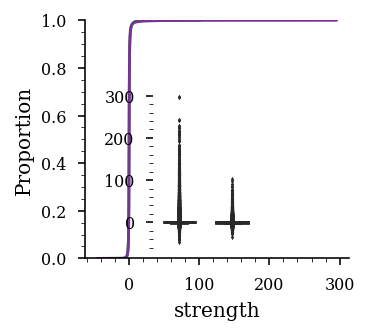

In [15]:
import custom_plots
group_colors = {"deep": "#7b3294", "sup": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, ax = plt.subplots(figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)), edgecolor=None)

custom_plots.plot_ecdf_box(
    data=react_df,
    x="strength",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    ax=ax,
    fig=fig)

    

In [40]:
np.hstack(results['assembly_act_pre'].data[sup_idx,:])

array([-0.08333431, -0.06820103, -0.03500706, ...,  0.07468035,
        0.07468035,  0.07468035])

In [49]:
epoch = results["react"].ripples[results["react"].epochs[0]]
assembly_id, strengths = assembly_reactivation.get_peak_activity(
    results["assembly_act_pre"], epoch
)


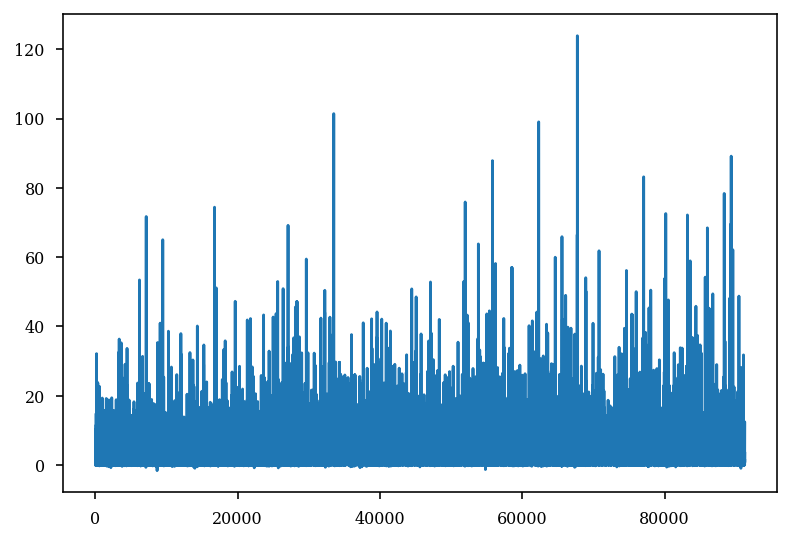

In [51]:
plt.plot(strengths)


In [5]:
import assembly_reactivation

basepath = r"Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"
m1 = assembly_reactivation.AssemblyReact(basepath)
m1.load_data()


In [6]:
print(m1.st, m1.ripples, m1.epochs)


<SpikeTrainArray at 0x1ff323b0ca0: 240 units> at 20000 Hz <EpochArray at 0x1ff323b0b80: 11,268 epochs> of length 12:16:036 minutes <EpochArray at 0x1ff3238eac0: 3 epochs> of length 9:41:01:103 hours


In [7]:
m1.get_weights(m1.ripples[m1.epochs[1]])


In [8]:
m1.get_assembly_act(epoch=m1.ripples[m1.epochs[0]])


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:392: UserWarning: Data is _not_ sorted! Data will be sorted automatically.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


In [26]:
import warnings

warnings.filterwarnings("ignore")
strengths = []
assembly_id = []
for assembly_act in m1.assembly_act[m1.ripples[m1.epochs[0]]]:
    strengths.append(assembly_act.max())
    assembly_id.append(np.arange(assembly_act.n_signals))


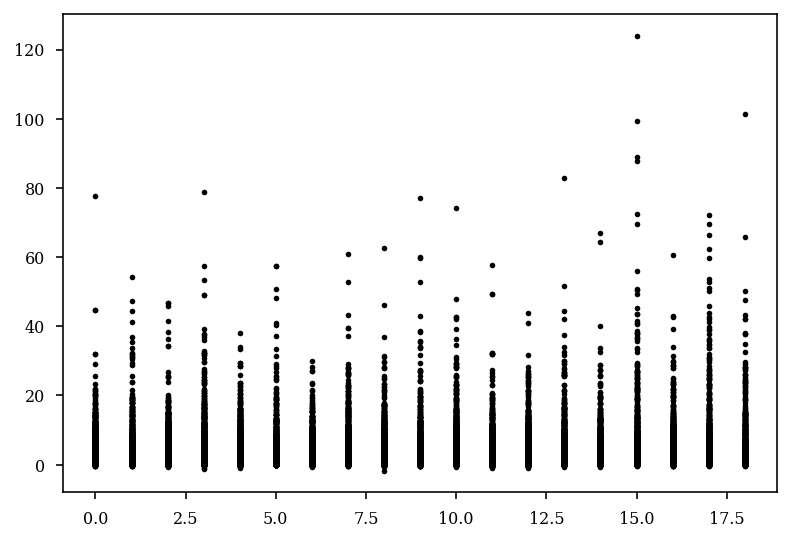

In [33]:
plt.plot(np.hstack(assembly_id), np.hstack(strengths), ".k")


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


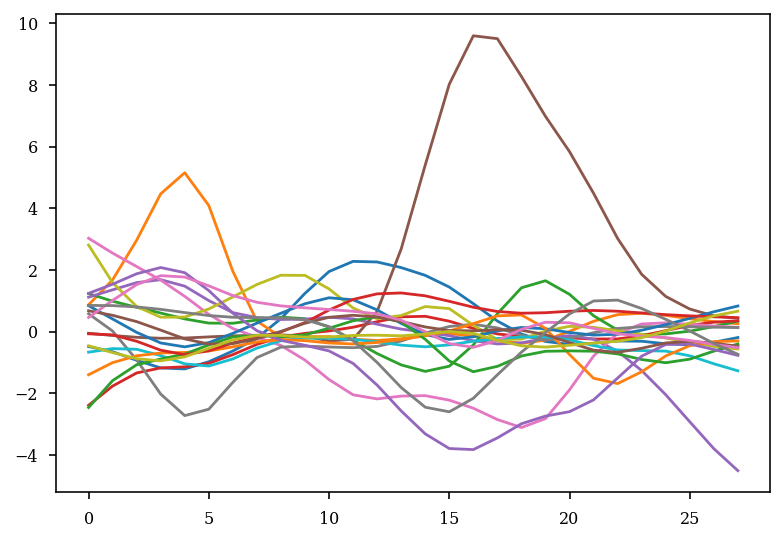

In [14]:
plt.plot(m1.assembly_act[2].data.T)
plt.show()


<AxesSubplot:>

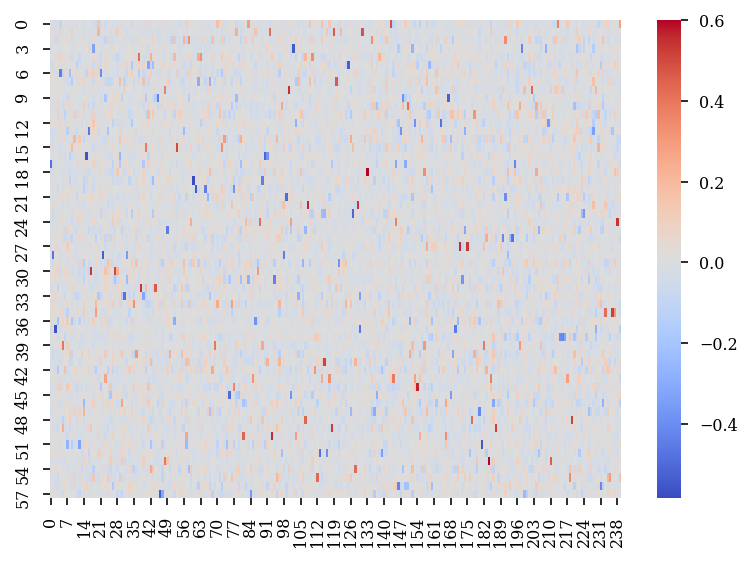

In [115]:
sns.heatmap(m1.patterns, cmap="coolwarm")


## discover assemblies on each epoch

In [4]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
df = df[df.basepath.str.contains("GrosmarkAD")]
df2 = pd.DataFrame()
#    'Z:\\Data\\AYAold\\AYA4\\day150804',
#    'Z:\\Data\\AYAold\\AYA7\\day19',
df2["basepath"] = ["Z:\Data\HMC1\day8", "Z:\\Data\\Kenji\\ec014.459_480"]
df = pd.concat([df, df2], ignore_index=True)
df
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_5ms'
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_10ms"
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_40ms'

assembly_individual_epochs.assembly_run(df, save_path, parallel=True)


## Load results and re-classify deep / sup

In [5]:
df = assembly_individual_epochs.load_assem_epoch_data(save_path)

LAYERDIST = 30
deep = -LAYERDIST
middle = [-LAYERDIST, LAYERDIST]
sup = LAYERDIST
df.loc[df.deepSuperficialDistance <= deep, "deepSuperficial"] = "Deep"
df.loc[
    (df.deepSuperficialDistance > middle[0]) & (df.deepSuperficialDistance < middle[1]),
    "deepSuperficial",
] = "middle"
df.loc[df.deepSuperficialDistance >= sup, "deepSuperficial"] = "Superficial"


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


### assembly weights over pre/task/post

In [6]:
df.loc[df.epoch_n == 0, "epoch_name"] = "Pre-sleep"
df.loc[df.epoch_n == 1, "epoch_name"] = "Task"
df.loc[df.epoch_n == 2, "epoch_name"] = "Post-sleep"


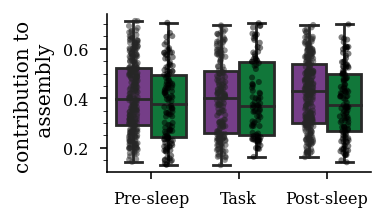

In [143]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

df["weights_abs"] = df.weights.abs()

w, h = functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1))
fig, ax = plt.subplots(figsize=(w, h / 1.5), edgecolor=None)
sns.boxplot(
    x="epoch_name",
    y="weights_abs",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=df[df.membership],
)

sns.stripplot(
    x="epoch_name",
    y="weights_abs",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=df[df.membership],
    dodge=True,
    color="k",
    alpha=0.5,
    s=3,
)

ax = plt.gca()
ax.set_ylabel("contribution to \n assembly")
ax.set_xlabel("")

# axs.legend(
#     loc="best", bbox_to_anchor=(1, -0.2, 0.5, 1.2), fontsize="x-small", frameon=False
# )

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_legend().remove()

plt.savefig(
    os.path.join(fig_save_path, "contribution_to_assembly_pre_task_post.svg"),
    dpi=300,
    bbox_inches="tight",
)


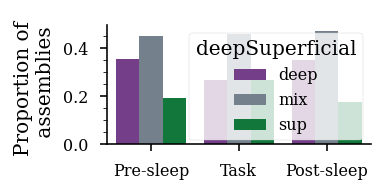

In [146]:
def get_assembly_composition(df):
    mixed = 0
    deep_biased = 0
    sup_biased = 0

    for n_as in df.assembly_n.unique():
        current_df = df[df.assembly_n == n_as]
        mem_idx = current_df.membership == True
        sup_idx = current_df.deepSuperficial == "Superficial"
        deep_idx = current_df.deepSuperficial == "Deep"

        if ((deep_idx & mem_idx).sum() > 0) & ((sup_idx & mem_idx).sum() > 0):
            mixed += 1
        elif ((deep_idx & mem_idx).sum() > 1) & ((sup_idx & mem_idx).sum() == 0):
            deep_biased += 1
        elif ((deep_idx & mem_idx).sum() == 0) & ((sup_idx & mem_idx).sum() > 0):
            sup_biased += 1
    return mixed, deep_biased, sup_biased


mixed_ps, deep_biased_ps, sup_biased_ps = get_assembly_composition(
    df[df.epoch_name == "Pre-sleep"]
)
mixed_t, deep_biased_t, sup_biased_t = get_assembly_composition(
    df[df.epoch_name == "Task"]
)
mixed_po, deep_biased_po, sup_biased_po = get_assembly_composition(
    df[df.epoch_name == "Post-sleep"]
)


df_comp = pd.DataFrame()
df_comp["composition"] = np.array(
    [
        mixed_ps,
        deep_biased_ps,
        sup_biased_ps,
        mixed_t,
        deep_biased_t,
        sup_biased_t,
        mixed_po,
        deep_biased_po,
        sup_biased_po,
    ]
)

df_comp["deepSuperficial"] = [
    "mix",
    "deep",
    "sup",
    "mix",
    "deep",
    "sup",
    "mix",
    "deep",
    "sup",
]
df_comp["epoch"] = [
    "Pre-sleep",
    "Pre-sleep",
    "Pre-sleep",
    "Task",
    "Task",
    "Task",
    "Post-sleep",
    "Post-sleep",
    "Post-sleep",
]

for epoch in df_comp.epoch.unique():
    df_comp.loc[df_comp.epoch == epoch, "composition_prop"] = (
        df_comp[df_comp.epoch == epoch].composition
        / df_comp[df_comp.epoch == epoch].composition.sum()
    )

w, h = functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1))

fig, ax = plt.subplots(figsize=(w, h / 2), edgecolor=None)

group_colors = {"deep": "#7b3294", "mix": "slategrey", "sup": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

g = sns.barplot(
    data=df_comp,
    x="epoch",
    y="composition_prop",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    ax=ax,
)

ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_ylabel("Proportion of \n assemblies")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.get_legend().remove()
ax.set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "compsition_of_assembly_pre_task_post.svg"),
    dpi=300,
    bbox_inches="tight",
)


## assembly similarity index

In [127]:
import itertools


def similarity_index(patterns):
    """
    Calculate the similarity index of a set of patterns.

    Based on Almeida-Filho et al., 2014 to detect similar assemblies.

    Input:
        patterns: list of patterns (n patterns x n neurons)
    Output:
        similarity index: float (0-1)
    """
    x = np.arange(0, patterns.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    si = []
    for i, s in enumerate(c):
        si.append(np.abs(np.inner(patterns[s[0], :], patterns[s[1], :])))

    return si, c


# results["assembly_act_pre"].patterns
patterns = results["react"].patterns
# patterns.shape
similarity_index(patterns)


# similarity_index(patterns[0,:])

# similarity_index(np.vstack([patterns[0,:],patterns[0,:]]))


[1.0000000000000002]

In [7]:
import assembly_corrs_deep_sup

save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_pre"
)
assembly_corrs_deep_sup.assembly_corr_run(df, save_path, parallel=True, epoch="pre")

save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_task"
)
assembly_corrs_deep_sup.assembly_corr_run(df, save_path, parallel=True, epoch="task")

save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_post"
)
assembly_corrs_deep_sup.assembly_corr_run(df, save_path, parallel=True, epoch="post")


In [8]:
save_paths = [
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_pre",
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_task",
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_post",
]

corr_df = pd.DataFrame()
for i, save_path in enumerate(save_paths):
    sessions = glob.glob(save_path + os.sep + "*.csv")
    for session in sessions:
        temp_df = pd.read_csv(session)
        temp_df["epoch"] = i
        corr_df = pd.concat([corr_df, temp_df], ignore_index=True)
corr_df


,Unnamed: 0,rho,label,assembly_id,basepath,epoch
0,0,-0.003529,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
1,1,-0.003555,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
2,2,0.013585,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
3,3,-0.029582,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
4,4,-0.003747,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
...,...,...,...,...,...,...
17575960,161335,0.037818,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2
17575961,161336,0.037095,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2
17575962,161337,0.127085,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2
17575963,161338,0.030874,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2


In [9]:
corr_df["label_2"] = "unknown"
idx = (corr_df.label == "member_deep") | (corr_df.label == "member_sup")
corr_df.loc[idx, "label_2"] = "member_same_layer"

idx = corr_df.label == "member_deep_sup"
corr_df.loc[idx, "label_2"] = "member_cross_layer"

idx = (
    (corr_df.label == "non_member_deep")
    | (corr_df.label == "non_member_sup")
    | (corr_df.label == "non_member_deep_sup")
)
corr_df.loc[idx, "label_2"] = "non_member"


In [50]:
corr_df.loc[corr_df.epoch == 0, "epoch_name"] = "Pre-sleep"
corr_df.loc[corr_df.epoch == 1, "epoch_name"] = "Task"
corr_df.loc[corr_df.epoch == 2, "epoch_name"] = "Post-sleep"


In [45]:
# get mean rho for each assembly_id in corr_df
# test_df = corr_df.groupby(by=['label_2','assembly_id','epoch'])['rho'].mean()
# test_df = test_df.reset_index()


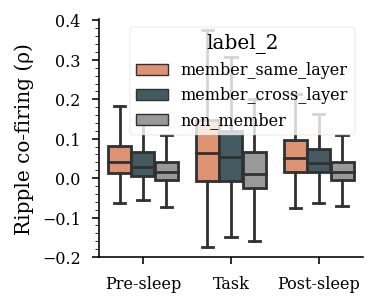

In [59]:
w, h = functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1))

fig, ax = plt.subplots(figsize=(w, h), edgecolor=None)
axs = plt.gca()

group_colors = {
    "member_same_layer": "#ef8a62",
    "member_cross_layer": "#3e5d66",
    "non_member": "#999999",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch_name",
    y="rho",
    hue="label_2",
    hue_order=group_colors.keys(),
    data=corr_df,
    fliersize=0.5,
    showfliers=False,
)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_ylabel("Ripple co-firing (ρ)")
axs.set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "assembly_member_correlation_pre_task_post.svg"),
    dpi=300,
    bbox_inches="tight",
)


## plot assembly activation strength by overall participation prob. over ripples 

See if, during the novel environment exploration, the first assemblies that appear are the ones formed by high-participation cells as well

of sig members, find mean/median/range/std participation prob per assembly

for assembly strength over time, locate any peak $R >= 5$.

In [110]:
patterns_keep, is_member_keep, keep_assembly, is_member = functions.find_sig_assemblies(
    results["patterns"][0]
)
patterns_keep.shape


(11, 60)

## Testing out different dt

In [ ]:
def load_assem_epoch_data(save_path):

    sessions = glob.glob(save_path + os.sep + "*.pkl")

    assem_epoch_df = pd.DataFrame()

    for session in sessions:
        assem_epoch_df_temp = pd.DataFrame()
        prob_sig_member = []
        n_members = []
        n_assemblies = []
        n_cells = []
        epoch = []
        with open(session, "rb") as f:
            results = pickle.load(f)

            for i, pattern_ep in enumerate(results["patterns"]):
                (
                    patterns_keep,
                    is_member_keep,
                    keep_assembly,
                    is_member,
                ) = functions.find_sig_assemblies(pattern_ep)
                prob_sig_member.append(np.mean(is_member_keep))
                n_members.append(is_member_keep.sum())
                n_assemblies.append(patterns_keep.shape[0])
                n_cells.append(patterns_keep.shape[1])
                epoch.append(str(i))

            assem_epoch_df_temp["prob_sig_member"] = prob_sig_member
            assem_epoch_df_temp["n_members"] = n_members
            assem_epoch_df_temp["n_assemblies"] = n_assemblies
            assem_epoch_df_temp["n_cells"] = n_cells
            assem_epoch_df_temp["epoch"] = epoch
            assem_epoch_df_temp["basepath"] = results["basepath"]

        assem_epoch_df = pd.concat(
            [assem_epoch_df, assem_epoch_df_temp], ignore_index=True
        )

    return assem_epoch_df


assem_epoch_df = pd.DataFrame()

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_5ms"
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp["binsize"] = "5ms"
assem_epoch_df = pd.concat([assem_epoch_df, assem_epoch_df_temp], ignore_index=True)

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_10ms"
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp["binsize"] = "10ms"
assem_epoch_df = pd.concat([assem_epoch_df, assem_epoch_df_temp], ignore_index=True)

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_20ms"
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp["binsize"] = "20ms"
assem_epoch_df = pd.concat([assem_epoch_df, assem_epoch_df_temp], ignore_index=True)

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_40ms"
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp["binsize"] = "40ms"
assem_epoch_df = pd.concat([assem_epoch_df, assem_epoch_df_temp], ignore_index=True)


In [10]:
assem_epoch_df["normalized_nassemb"] = (
    assem_epoch_df.n_assemblies / assem_epoch_df.n_cells
)


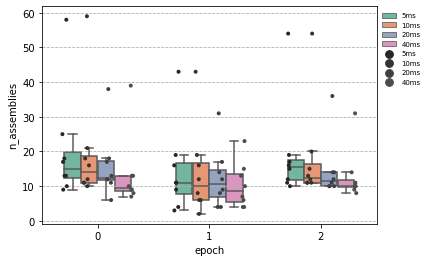

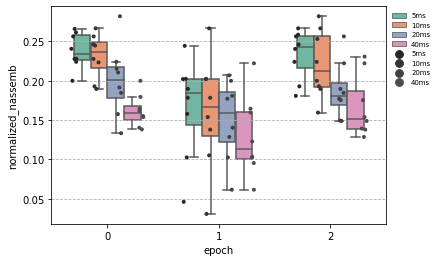

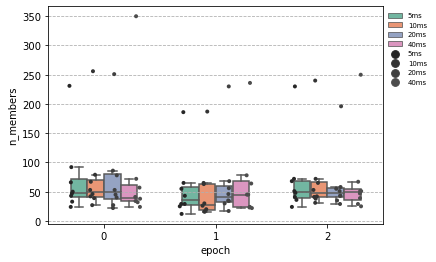

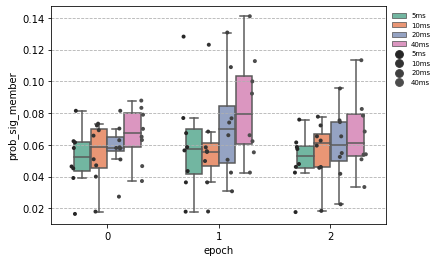

In [11]:
plt.figure()
plt.grid(linestyle="--", zorder=-100)
sns.boxplot(
    x="epoch",
    y="n_assemblies",
    hue="binsize",
    data=assem_epoch_df,
    width=0.6,
    palette="Set2",
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="n_assemblies",
    hue="binsize",
    data=assem_epoch_df,
    size=4,
    color=".3",
    linewidth=0,
    dodge=True,
)
axs = plt.gca()
axs.legend(
    loc="best", bbox_to_anchor=(0.65, -0.2, 0.5, 1.2), fontsize="x-small", frameon=False
)


plt.figure()
plt.grid(linestyle="--", zorder=-100)
sns.boxplot(
    x="epoch",
    y="normalized_nassemb",
    hue="binsize",
    data=assem_epoch_df,
    width=0.6,
    palette="Set2",
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="normalized_nassemb",
    hue="binsize",
    data=assem_epoch_df,
    size=4,
    color=".3",
    linewidth=0,
    dodge=True,
)
axs = plt.gca()
axs.legend(
    loc="best", bbox_to_anchor=(0.65, -0.2, 0.5, 1.2), fontsize="x-small", frameon=False
)

plt.figure()
plt.grid(linestyle="--", zorder=-100)
sns.boxplot(
    x="epoch",
    y="n_members",
    hue="binsize",
    data=assem_epoch_df,
    width=0.6,
    palette="Set2",
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="n_members",
    hue="binsize",
    data=assem_epoch_df,
    size=4,
    color=".3",
    linewidth=0,
    dodge=True,
)
axs = plt.gca()
axs.legend(
    loc="best", bbox_to_anchor=(0.65, -0.2, 0.5, 1.2), fontsize="x-small", frameon=False
)

plt.figure()
plt.grid(linestyle="--", zorder=-100)
sns.boxplot(
    x="epoch",
    y="prob_sig_member",
    hue="binsize",
    data=assem_epoch_df,
    width=0.6,
    palette="Set2",
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="prob_sig_member",
    hue="binsize",
    data=assem_epoch_df,
    size=4,
    color=".3",
    linewidth=0,
    dodge=True,
)
axs = plt.gca()
axs.legend(
    loc="best", bbox_to_anchor=(0.65, -0.2, 0.5, 1.2), fontsize="x-small", frameon=False
)
